<a href="https://colab.research.google.com/github/novtryrezki/Terbaru/blob/main/1CNN_bs_64_ep_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path ='/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
list_train = sorted(os.listdir(train_dir))
list_test = sorted(os.listdir(test_dir))

print("Daftar Angka pada Dataset Train yaitu : ", list_train)
print("Daftar Angka pada Dataset Test yaitu : ", list_test)

Daftar Angka pada Dataset Train yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']
Daftar Angka pada Dataset Test yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']


In [4]:
def count_images(directory):
    return sum(1 for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png', '.gif')))

# Menghitung jumlah gambar di data train
train_image_count = sum(count_images(os.path.join(train_dir, angka)) for angka in list_train)

# Menghitung jumlah gambar di data test
test_image_count = sum(count_images(os.path.join(test_dir, angka)) for angka in list_test)

print(f"Jumlah gambar di Dataset Train: {train_image_count}")
print(f"Jumlah gambar di Dataset Test: {test_image_count}")

Jumlah gambar di Dataset Train: 1763
Jumlah gambar di Dataset Test: 445


# Preprocessing

In [5]:
import cv2

def resize_images(directory, target_resolution):
    for angka in os.listdir(directory):
        angka_dir = os.path.join(directory, angka)
        for file_name in os.listdir(angka_dir):
            file_path = os.path.join(angka_dir, file_name)
            img = cv2.imread(file_path)
            resized_img = cv2.resize(img, (target_resolution[0], target_resolution[1]))
            cv2.imwrite(file_path, resized_img)

target_resolution = (52, 78)
resize_images(train_dir, target_resolution)
resize_images(test_dir, target_resolution)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat generator data dengan augmentasi
image_size = (52, 78)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1763 images belonging to 10 classes.
Found 445 images belonging to 10 classes.


# Membuat Model CNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import math

img_size = 52*78*1

# Perhitungan jumlah neuron pada lapisan tersembunyi
hidden_neurons = 201

model1c = Sequential()
model1c.add(Conv2D(32, (3, 3), activation='relu', input_shape=(52, 78, 1)))
model1c.add(AveragePooling2D((2, 2)))
model1c.add(Conv2D(64, (3, 3), activation='relu'))
model1c.add(AveragePooling2D((2, 2)))
model1c.add(Flatten())
model1c.add(Dense(hidden_neurons, activation='relu'))
model1c.add(Dense(10, activation='softmax'))

model1c.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Mendapatkan bobot dari model
weights = []
for layer in model1c.layers:
    weights.append(layer.get_weights())

print("Bobot dari model:")
for i, layer_weights in enumerate(weights):
    print("Layer", i+1)
    for j, w in enumerate(layer_weights):
        print("  Bobot {}: {}".format(j+1, w.shape))

Bobot dari model:
Layer 1
  Bobot 1: (3, 3, 1, 32)
  Bobot 2: (32,)
Layer 2
Layer 3
  Bobot 1: (3, 3, 32, 64)
  Bobot 2: (64,)
Layer 4
Layer 5
Layer 6
  Bobot 1: (12672, 201)
  Bobot 2: (201,)
Layer 7
  Bobot 1: (201, 10)
  Bobot 2: (10,)


In [9]:
model1c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 76, 32)        320       
                                                                 
 average_pooling2d (Average  (None, 25, 38, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 36, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 11, 18, 64)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 12672)             0         
                                                                 
 dense (Dense)               (None, 201)               2

In [10]:
history = model1c.fit(train_generator, epochs=20, verbose = 1)

Epoch 1/20
28/28 [==============================] - 17s 521ms/step - loss: 2.0849 - accuracy: 0.2819
Epoch 2/20
28/28 [==============================] - 9s 308ms/step - loss: 1.9990 - accuracy: 0.3239
Epoch 3/20
28/28 [==============================] - 8s 288ms/step - loss: 1.9658 - accuracy: 0.3789
Epoch 4/20
28/28 [==============================] - 7s 240ms/step - loss: 1.9267 - accuracy: 0.3710
Epoch 5/20
28/28 [==============================] - 7s 254ms/step - loss: 1.8969 - accuracy: 0.3806
Epoch 6/20
28/28 [==============================] - 9s 305ms/step - loss: 1.8748 - accuracy: 0.3834
Epoch 7/20
28/28 [==============================] - 8s 295ms/step - loss: 1.8498 - accuracy: 0.3988
Epoch 8/20
28/28 [==============================] - 7s 246ms/step - loss: 1.8419 - accuracy: 0.3919
Epoch 9/20
28/28 [==============================] - 7s 241ms/step - loss: 1.8229 - accuracy: 0.3914
Epoch 10/20
28/28 [==============================] - 8s 300ms/step - loss: 1.8276 - accuracy: 0.388

In [11]:
# Inisialisasi dictionary untuk menyimpan bobot dan bias dari setiap layer
weights_biases = {}

# Loop melalui semua layer dalam model yang sudah dimuat
for layer in model1c.layers:
    # Periksa apakah layer adalah lapisan Conv2D atau AveragePooling2D
    if isinstance(layer, Conv2D) or isinstance(layer, AveragePooling2D):
        # Periksa apakah layer memiliki bobot dan bias
        if layer.get_weights():
            # Peroleh bobot dari lapisan
            weights, biases = layer.get_weights()
            # Simpan bobot dan bias dalam dictionary dengan menggunakan nama layer
            weights_biases[layer.name] = {'weights': weights, 'biases': biases}
    # Periksa apakah layer adalah lapisan Dense
    elif isinstance(layer, Dense):
        # Periksa apakah layer memiliki bobot dan bias
        if layer.get_weights():
            # Peroleh bobot dari lapisan
            weights, biases = layer.get_weights()
            # Simpan bobot dan bias dalam dictionary dengan menggunakan nama layer
            weights_biases[layer.name] = {'weights': weights, 'biases': biases}

# Loop melalui semua layer dalam model dan cetak informasi tentang bobot dan bias
for layer_name, params in weights_biases.items():
    print(f"Layer Name: {layer_name}")
    print("Weight Matrix Shape:", params['weights'].shape)  # Ukuran matriks bobot
    print("Weight Matrix:")
    print(params['weights'])  # Bobot
    print("Bias Vector Shape:", params['biases'].shape)    # Ukuran vektor bias
    print("Bias Vector:")
    print(params['biases'])    # Bias
    print("-----------------------------------")

Layer Name: conv2d
Weight Matrix Shape: (3, 3, 1, 32)
Weight Matrix:
[[[[ 3.21208090e-02 -1.20059900e-01  3.86722982e-02 -1.17016308e-01
    -1.38284296e-01 -6.20505027e-02 -8.86880383e-02  1.19999640e-01
     2.87653692e-02 -1.11689426e-01 -8.33541453e-02  1.06408753e-01
    -1.01061851e-01  1.19660445e-01 -1.27146859e-02 -2.77801678e-02
    -1.38449311e-01 -3.03099304e-02 -1.18554523e-03  2.44312882e-02
     7.68624917e-02  1.27587959e-01 -4.95079979e-02 -9.96199250e-02
     2.89259329e-02 -5.99786267e-02  1.11146860e-01  5.16807809e-02
    -2.14716792e-03 -6.88251927e-02  3.91475819e-02  1.47216499e-01]]

  [[ 5.42724505e-02  1.36324331e-01  7.43216500e-02  1.29057139e-01
     1.14522040e-01  5.82575090e-02 -4.05036584e-02  5.83172664e-02
     6.82370812e-02  1.88979208e-02 -1.10931925e-01 -3.25630531e-02
     1.39923990e-01  5.52697927e-02 -1.33695394e-01 -7.26387724e-02
    -1.66611448e-02 -4.75328565e-02  1.09861895e-01  5.64533994e-02
     8.76585096e-02  1.06545456e-01 -5.69484

In [12]:
from google.colab import files

uploaded = files.upload()
# Baca gambar yang diunggah
for fn in uploaded.keys():
    # Baca gambar menggunakan OpenCV
    img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)  # Ubah ke skala keabuan (grayscale) jika perlu
    # Lakukan pra-pemrosesan, seperti resize gambar ke ukuran yang sesuai dengan model Anda
    img_resized = cv2.resize(img, (78, 52))  # Sesuaikan ukuran dengan kebutuhan model Anda

# Ubah gambar menjadi array numpy dan lakukan normalisasi jika diperlukan
X_test_sample = np.array(img_resized).reshape(1, -1)
X_test_sample = X_test_sample / 255.0  # Normalisasi

Saving 20231206_091207.jpg to 20231206_091207 (6).jpg


**LAPISAN CONV2D PERTAMA**

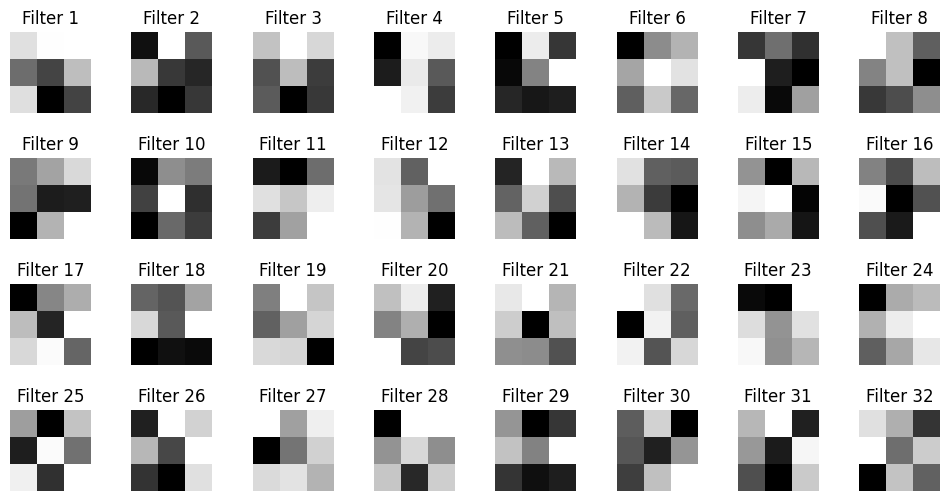

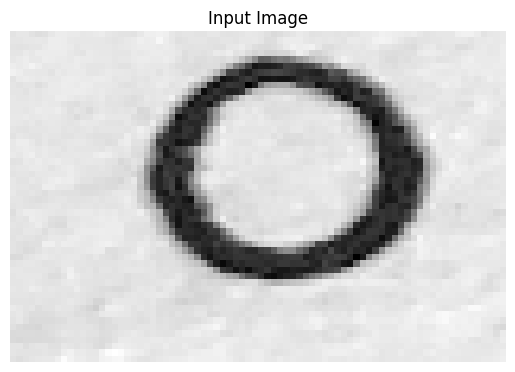

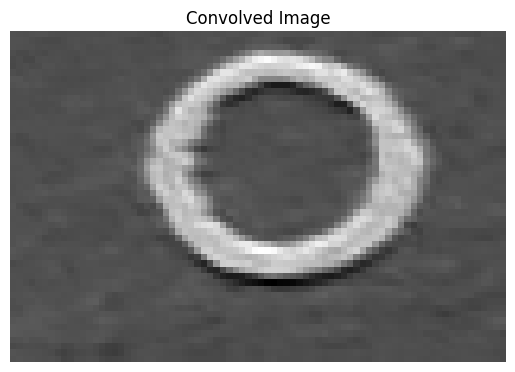

In [13]:
import matplotlib.pyplot as plt

# Ambil bobot dari layer Conv2D pertama
conv_weights = model1c.layers[0].get_weights()[0]

# Tampilkan filter
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(conv_weights[:, :, 0, i*8 + j], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Filter {i*8 + j + 1}')
plt.show()

# Ambil matriks input gambar
input_image = X_test_sample.reshape(52, 78)

# Tampilkan matriks input gambar
plt.imshow(input_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

# Hitung hasil operasi konvolusi untuk matriks input gambar
convolved_image = cv2.filter2D(input_image, -1, conv_weights[:, :, 0, 0])

# Tampilkan hasil operasi konvolusi
plt.imshow(convolved_image, cmap='gray')
plt.title('Convolved Image')
plt.axis('off')
plt.show()

**FILTER**

In [14]:
# Ambil bobot dari layer Conv2D pertama
conv_weights = model1c.layers[0].get_weights()[0]

# Tampilkan matriks kernel atau filter berukuran 3x3 sebanyak 32
for i in range(32):
    print(f'Filter {i + 1}:')
    print(conv_weights[:, :, 0, i])

Filter 1:
[[ 0.03212081  0.05427245  0.05548748]
 [-0.05355645 -0.08454896  0.00662514]
 [ 0.03115625 -0.13539775 -0.08493776]]
Filter 2:
[[-0.1200599   0.13632433 -0.04064858]
 [ 0.06099786 -0.07587478 -0.09644158]
 [-0.09245694 -0.1373257  -0.07841887]]
Filter 3:
[[ 0.0386723   0.07432165  0.05094455]
 [-0.02572655  0.03605795 -0.03813738]
 [-0.0206019  -0.07325384 -0.04069432]]
Filter 4:
[[-0.11701631  0.12905714  0.11695662]
 [-0.08861052  0.11446903 -0.02732103]
 [ 0.13620307  0.12221427 -0.05572658]]
Filter 5:
[[-0.1382843   0.11452204 -0.07964668]
 [-0.12959258  0.0036063   0.13486555]
 [-0.09761036 -0.11317793 -0.10591745]]
Filter 6:
[[-0.0620505   0.05825751  0.09290271]
 [ 0.0795632   0.15716906  0.13189527]
 [ 0.01952859  0.11034079  0.02676277]]
Filter 7:
[[-0.08868804 -0.04050366 -0.0930537 ]
 [ 0.08133062 -0.10896451 -0.1350281 ]
 [ 0.06530993 -0.12702079  0.00087406]]
Filter 8:
[[ 0.11999964  0.05831727 -0.03714923]
 [-0.0003865   0.05830124 -0.13055508]
 [-0.07412985 -0

**MATRIKS INPUT**

In [15]:
import cv2

# Ambil bobot dari layer Conv2D pertama
conv_weights = model1c.layers[0].get_weights()[0]

# Ambil matriks input gambar
input_image = X_test_sample.reshape(52, 78)

# Tampilkan ukuran matriks hasil operasi konvolusi
print("Ukuran Convolved Image Matrix:", input_image.shape)

# Tampilkan matriks input gambar
print("Input Image Matrix:")
print(input_image)

Ukuran Convolved Image Matrix: (52, 78)
Input Image Matrix:
[[0.61568627 0.62352941 0.62352941 ... 0.62352941 0.62745098 0.63137255]
 [0.61960784 0.61960784 0.62352941 ... 0.63137255 0.62745098 0.63137255]
 [0.61568627 0.61176471 0.61568627 ... 0.62352941 0.62745098 0.63921569]
 ...
 [0.61960784 0.61960784 0.60392157 ... 0.61960784 0.62745098 0.62745098]
 [0.61960784 0.61568627 0.61568627 ... 0.62352941 0.63137255 0.63921569]
 [0.61176471 0.60392157 0.61176471 ... 0.63137255 0.63529412 0.64313725]]


**Filter 1**

In [16]:
from scipy.signal import convolve2d

# Ambil bobot dari layer Conv2D pertama
conv_weights = model1c.layers[0].get_weights()[0]

# Ambil matriks input gambar
input_image = X_test_sample.reshape(52, 78)

# Pilih filter yang ingin ditampilkan hasil konvolusinya
filter_index = 0  # Ganti dengan indeks filter yang ingin ditampilkan

# Hitung hasil operasi konvolusi untuk matriks input gambar dan filter yang dipilih
convolved_image = convolve2d(input_image, conv_weights[:, :, 0, filter_index], mode='valid')

# Setel opsi tampilan numpy untuk menampilkan seluruh array
np.set_printoptions(threshold=np.inf)

# Tampilkan ukuran matriks hasil operasi konvolusi
print(f"Ukuran Convolved Image Matrix dari Filter {filter_index + 1}: {convolved_image.shape}")

# Tampilkan matriks hasil operasi konvolusi dari filter yang dipilih
print(f"Convolved Image Matrix dari Filter {filter_index + 1}:")
print(convolved_image)

Ukuran Convolved Image Matrix dari Filter 1: (50, 76)
Convolved Image Matrix dari Filter 1:
[[-0.11182769 -0.11307078 -0.11147584 -0.1088185  -0.10778669 -0.1101509
  -0.11245299 -0.11316162 -0.1125918  -0.11282764 -0.11189663 -0.11133001
  -0.11228472 -0.1135229  -0.11196963 -0.11055288 -0.11034521 -0.11042509
  -0.10975867 -0.11117897 -0.11388657 -0.11686639 -0.11830967 -0.11586805
  -0.11148712 -0.1086073  -0.11031922 -0.11171611 -0.11113794 -0.1100488
  -0.11078641 -0.1125994  -0.11203651 -0.10947789 -0.10830692 -0.10947632
  -0.11207159 -0.11421415 -0.11339942 -0.11096241 -0.10852052 -0.10844197
  -0.10910067 -0.10903    -0.11033269 -0.10952824 -0.10742872 -0.10867499
  -0.11188724 -0.11341297 -0.11151941 -0.11129553 -0.11176655 -0.11119707
  -0.11261888 -0.11414674 -0.11566973 -0.1184908  -0.11885843 -0.11709538
  -0.11570663 -0.11436284 -0.1151119  -0.11356109 -0.10968331 -0.10939571
  -0.11095159 -0.1122738  -0.11225916 -0.11597754 -0.11810646 -0.11765667
  -0.11609123 -0.11149

**FILTER 2**

In [17]:
from scipy.signal import convolve2d

# Ambil bobot dari layer Conv2D pertama
conv_weights = model1c.layers[0].get_weights()[0]

# Ambil matriks input gambar
input_image = X_test_sample.reshape(52, 78)

# Pilih filter yang ingin ditampilkan hasil konvolusinya
filter_index = 1  # Ganti dengan indeks filter yang ingin ditampilkan

# Hitung hasil operasi konvolusi untuk matriks input gambar dan filter yang dipilih
convolved_image = convolve2d(input_image, conv_weights[:, :, 0, filter_index], mode='valid')

# Setel opsi tampilan numpy untuk menampilkan seluruh array
np.set_printoptions(threshold=np.inf)

# Tampilkan ukuran matriks hasil operasi konvolusi
print(f"Ukuran Convolved Image Matrix dari Filter {filter_index + 1}: {convolved_image.shape}")

# Tampilkan matriks hasil operasi konvolusi dari filter yang dipilih
print(f"Convolved Image Matrix dari Filter {filter_index + 1}:")
print(convolved_image)

Ukuran Convolved Image Matrix dari Filter 2: (50, 76)
Convolved Image Matrix dari Filter 2:
[[-0.27583985 -0.27544153 -0.27286458 -0.27333615 -0.27317159 -0.27694197
  -0.28138767 -0.28219232 -0.27988243 -0.28018185 -0.27754173 -0.27767578
  -0.27941902 -0.27925715 -0.27705734 -0.27532412 -0.27369581 -0.27385542
  -0.27519915 -0.27987012 -0.28371406 -0.28294181 -0.28772193 -0.28595396
  -0.27900759 -0.27478685 -0.27260222 -0.27436649 -0.27389035 -0.27447498
  -0.27502073 -0.27405101 -0.27493035 -0.27346736 -0.27432964 -0.27332465
  -0.2754378  -0.27648686 -0.27549298 -0.27079364 -0.26583644 -0.26898856
  -0.2744165  -0.27635544 -0.28075622 -0.27847797 -0.2717384  -0.2728884
  -0.27482167 -0.27607522 -0.27539755 -0.27304241 -0.2747756  -0.27684093
  -0.28033378 -0.27928904 -0.28006561 -0.2865103  -0.28583142 -0.28428975
  -0.28104563 -0.27921309 -0.27901571 -0.27577942 -0.27432359 -0.27296752
  -0.27672122 -0.27615406 -0.27591123 -0.28217625 -0.28542691 -0.28323526
  -0.27875365 -0.2759

**FILTER 32**

In [18]:
from scipy.signal import convolve2d

# Ambil bobot dari layer Conv2D pertama
conv_weights = model1c.layers[0].get_weights()[0]

# Ambil matriks input gambar
input_image = X_test_sample.reshape(52, 78)

# Pilih filter yang ingin ditampilkan hasil konvolusinya
filter_index = 31  # Ganti dengan indeks filter yang ingin ditampilkan

# Hitung hasil operasi konvolusi untuk matriks input gambar dan filter yang dipilih
convolved_image = convolve2d(input_image, conv_weights[:, :, 0, filter_index], mode='valid')

# Setel opsi tampilan numpy untuk menampilkan seluruh array
np.set_printoptions(threshold=np.inf)

# Tampilkan ukuran matriks hasil operasi konvolusi
print(f"Ukuran Convolved Image Matrix dari Filter {filter_index + 1}: {convolved_image.shape}")

# Tampilkan matriks hasil operasi konvolusi dari filter yang dipilih
print(f"Convolved Image Matrix dari Filter {filter_index + 1}:")
print(convolved_image)


Ukuran Convolved Image Matrix dari Filter 32: (50, 76)
Convolved Image Matrix dari Filter 32:
[[0.57779397 0.57931045 0.57944841 0.57921794 0.5848304  0.589777
  0.59384734 0.59199546 0.5872371  0.58491056 0.58375896 0.58358788
  0.58402013 0.5837289  0.58084609 0.57923476 0.58034946 0.58305159
  0.58746739 0.590468   0.59552989 0.59938273 0.59854303 0.59623891
  0.58408463 0.57664173 0.57438151 0.57569243 0.57651214 0.57471471
  0.5740417  0.57402417 0.57567061 0.57751612 0.58122014 0.58116244
  0.58034487 0.57553369 0.56877339 0.56479894 0.56536408 0.5742667
  0.58550994 0.59104428 0.59153269 0.59015573 0.58401798 0.57736378
  0.57488715 0.57449365 0.57598234 0.5793857  0.58102035 0.58287466
  0.58650594 0.59165755 0.59434227 0.5959304  0.59273466 0.58632191
  0.57885931 0.57317341 0.57450288 0.57708432 0.57995661 0.5790549
  0.57995609 0.58024009 0.57916645 0.57916245 0.58080805 0.58531929
  0.58632753 0.58540017 0.58453526 0.58838499]
 [0.57854607 0.57975538 0.58240893 0.58631484 0

**LAPISAN AVERAGE POOLING PERTAMA**

In [20]:
from tensorflow.keras.models import Model

# Ambil output dari Conv2D pertama
filter_output = model1c.layers[0].output

# Tentukan ukuran pooling window
pool_size = (2, 2)

# Lakukan operasi average pooling
pooled_output = AveragePooling2D(pool_size=pool_size)(filter_output)

# Inisialisasi model untuk mengambil output dari layer AveragePooling2D
model = Model(inputs=model1c.input, outputs=pooled_output)

# Siapkan data input untuk pengujian (misalnya, X_test_sample)
input_image = X_test_sample.reshape(-1, 52, 78, 1)

# Lakukan prediksi menggunakan model untuk mendapatkan output setelah average pooling
output_after_pooling = model.predict(input_image)
print("Ukuran :", output_after_pooling.shape)

1/1 [==============================] - 0s 146ms/step
Ukuran : (1, 25, 38, 32)


In [21]:
print(output_after_pooling[:1])

[[[[0.00000000e+00 0.00000000e+00 2.33520404e-05 1.77626491e-01
    0.00000000e+00 3.30979288e-01 0.00000000e+00 0.00000000e+00
    1.40683830e-01 0.00000000e+00 1.40401408e-01 1.98929816e-01
    4.54304856e-04 3.18676710e-01 0.00000000e+00 0.00000000e+00
    0.00000000e+00 0.00000000e+00 1.24561533e-01 0.00000000e+00
    1.94932953e-01 3.10500354e-01 3.03048342e-01 3.50174874e-01
    6.69598207e-02 2.15098217e-01 1.90602332e-01 6.25197291e-01
    0.00000000e+00 0.00000000e+00 1.27375172e-03 4.63128030e-01]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.77222192e-01
    0.00000000e+00 3.32715034e-01 0.00000000e+00 0.00000000e+00
    1.40365005e-01 0.00000000e+00 1.43673718e-01 1.99033752e-01
    0.00000000e+00 3.20239007e-01 0.00000000e+00 0.00000000e+00
    0.00000000e+00 0.00000000e+00 1.23948574e-01 0.00000000e+00
    1.95051789e-01 3.11909765e-01 3.05727601e-01 3.52381706e-01
    6.88669384e-02 2.14900300e-01 1.91059947e-01 6.27762318e-01
    0.00000000e+00 0.00000000e+00 7.526

In [22]:
ab = output_after_pooling[:1]
print("Ukuran :",ab.shape)

Ukuran : (1, 25, 38, 32)


**LAPISAN KONVOLUSI KEDUA**

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D

# Ambil bobot dari layer Conv2D kedua
conv_weights_2 = model1c.layers[2].get_weights()[0]

# Hitung hasil operasi konvolusi untuk output dari lapisan pooling pertama dan filter pertama
convolved_image_2 = cv2.filter2D(output_after_pooling[0, :, :, 0], -1, conv_weights_2[:, :, 0, 0])

**FILTER**

In [25]:
# Ambil bobot dari layer Conv2D kedua
conv_weights_2 = model1c.layers[2].get_weights()[0]

# Tampilkan matriks kernel atau filter berukuran 3x3 sebanyak 64
for i in range(64):
    print(f'Filter {i + 1} (Layer Conv2D kedua):')
    print(conv_weights_2[:, :, 0, i])


Filter 1 (Layer Conv2D kedua):
[[ 0.00590141  0.05582765 -0.02310379]
 [ 0.04346107  0.01963367 -0.07004101]
 [ 0.07789978  0.01272007 -0.07163569]]
Filter 2 (Layer Conv2D kedua):
[[ 0.06824481  0.03058225 -0.053241  ]
 [-0.05132964 -0.07188817 -0.05325202]
 [ 0.05148997 -0.07500446  0.0195327 ]]
Filter 3 (Layer Conv2D kedua):
[[ 0.03711523  0.06723405 -0.0243611 ]
 [-0.0534637   0.0474819  -0.07474214]
 [-0.05632943 -0.05248613  0.00860945]]
Filter 4 (Layer Conv2D kedua):
[[ 0.06649224 -0.07529436 -0.01366568]
 [-0.00202952 -0.00941083 -0.00448092]
 [-0.00210803 -0.0357779  -0.07765096]]
Filter 5 (Layer Conv2D kedua):
[[ 0.03106158 -0.03813714  0.05163962]
 [ 0.05963324  0.01348468 -0.07684322]
 [-0.07535484  0.07003456  0.03627845]]
Filter 6 (Layer Conv2D kedua):
[[-0.01759378  0.04564239  0.06452504]
 [ 0.02942972 -0.00522395 -0.02587682]
 [ 0.0727471   0.08245658  0.04008298]]
Filter 7 (Layer Conv2D kedua):
[[-0.04845355 -0.07065009 -0.01217552]
 [-0.03960712  0.06060127  0.0783077

**FILTER PERTAMA**

In [28]:
from scipy.signal import convolve2d

# Ambil bobot dari layer Conv2D kedua
conv_weights_2 = model1c.layers[2].get_weights()[0]

# Pilih filter yang ingin digunakan untuk operasi konvolusi (misalnya, filter pertama)
filter_index = 0

# Hitung hasil operasi konvolusi untuk output lapisan pooling pertama dan filter yang dipilih
convolved_image_2 = convolve2d(output_after_pooling[0, :, :, filter_index], conv_weights_2[:, :, 0, filter_index], mode='valid')

# Tampilkan hasil operasi konvolusi
print(f"Ukuran Convolved Image Matrix dari Filter {filter_index + 1}: {convolved_image_2.shape}")
print(f"Convolved Image Matrix dari Filter {filter_index + 1}:")
print(convolved_image_2)

Ukuran Convolved Image Matrix dari Filter 1: (23, 36)
Convolved Image Matrix dari Filter 1:
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  5.8747307e-08
   4.6185909e-05  3.0679649e-04  1.4950392e-04 -4.1926952e-04
  -1.3452796e-04  1.8892543e-04  2.5528125e-04 -1.2679533e-04
   5.1300402e-05 -2.1230231e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  4.3264589e-07
   8.1983104e-05  5.2602519e-04  1.7647905e-04 -4.4467649e-04
  -3.3580676e-05  3.0328336e-04 -8.2294

**FILTER KEDUA**

In [30]:
# Pilih filter yang ingin digunakan untuk operasi konvolusi (misalnya, filter kedua)
filter_index = 1

# Hitung hasil operasi konvolusi untuk output lapisan pooling pertama dan filter yang dipilih
convolved_image_2 = convolve2d(output_after_pooling[0, :, :, filter_index], conv_weights_2[:, :, 0, filter_index], mode='valid')

# Tampilkan hasil operasi konvolusi
print(f"Ukuran Convolved Image Matrix dari Filter {filter_index + 1}: {convolved_image_2.shape}")
print(f"Convolved Image Matrix dari Filter {filter_index + 1}:")
print(convolved_image_2)


Ukuran Convolved Image Matrix dari Filter 2: (23, 36)
Convolved Image Matrix dari Filter 2:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0.

**FILTER KE 64**

In [32]:
from scipy.signal import convolve2d

# Pilih filter ke-64 untuk operasi konvolusi
filter_index = 31

# Hitung hasil operasi konvolusi untuk output lapisan pooling pertama dan filter ke-64
convolved_image_64 = convolve2d(output_after_pooling[0, :, :, filter_index], conv_weights_2[:, :, 0, filter_index], mode='valid')

# Tampilkan hasil operasi konvolusi
print(f"Ukuran Convolved Image Matrix dari Filter ke-64: {convolved_image_64.shape}")
print(f"Convolved Image Matrix dari Filter ke-64:")
print(convolved_image_64)

Ukuran Convolved Image Matrix dari Filter ke-64: (23, 36)
Convolved Image Matrix dari Filter ke-64:
[[ 0.01102844  0.01006276  0.01035356  0.01113857  0.01069376  0.01052981
   0.0106805   0.01069491  0.01027221  0.00976702  0.0092813   0.00923909
   0.00859246  0.00497717 -0.00605413 -0.02062219 -0.03066871 -0.03272228
  -0.02721232 -0.02348718 -0.02412163 -0.02279405 -0.01614035 -0.00818111
  -0.00174094  0.00497539  0.00897136  0.00955195  0.01027483  0.01229937
   0.01253145  0.01137848  0.01125804  0.01194187  0.01178837  0.01123074]
 [ 0.00962836  0.01057891  0.01157429  0.01148391  0.01107968  0.01090859
   0.01049758  0.01012338  0.00999849  0.01041999  0.01018556  0.00842917
   0.00011768 -0.0175815  -0.03381155 -0.03389794 -0.02087056 -0.00379278
   0.00685603  0.00422017 -0.00297608 -0.00990347 -0.01368098 -0.01755354
  -0.01724212 -0.00965922  0.00153933  0.0099598   0.01253042  0.01163631
   0.01102603  0.01061785  0.0114744   0.01096981  0.00997413  0.01035256]
 [ 0.01067

In [ ]:
print("Ukuran :", conv_weights_2.shape)
filter_index

**LAPISAN AVERAGE_POOLNG_2**

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D

# Ambil output dari Conv2D pertama
pooling2_output = model1c.layers[2].output

# Tentukan ukuran pooling window
pool_size = (2, 2)

# Lakukan operasi average pooling
pooled_output2 = AveragePooling2D(pool_size=pool_size)(pooling2_output)

# Inisialisasi model untuk mengambil output dari layer AveragePooling2D
model_pooling2_output = Model(inputs=model1c.input, outputs=pooled_output2)

# Siapkan data input untuk pengujian
input_data = X_test_sample.reshape(-1, 52, 78, 1)

# Lakukan prediksi menggunakan model untuk mendapatkan output dari lapisan pooling pertama
output_after_pooling1 = model_pooling2_output.predict(input_data)

# Tampilkan matriks hasil operasi konvolusi
print("Ukuran : ", output_after_pooling1.shape)
print(output_after_pooling1)

1/1 [==============================] - 0s 56ms/step
Ukuran :  (1, 11, 18, 64)
[[[[0.00000000e+00 0.00000000e+00 5.58081627e-01 1.56545982e-01
    0.00000000e+00 4.31760520e-01 0.00000000e+00 0.00000000e+00
    4.71197307e-01 0.00000000e+00 0.00000000e+00 2.23598599e-01
    4.67541367e-01 0.00000000e+00 0.00000000e+00 3.66498902e-03
    3.64554912e-01 7.42140770e-01 2.13015929e-01 0.00000000e+00
    0.00000000e+00 5.67199429e-04 0.00000000e+00 4.00785238e-01
    4.86896455e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
    3.50200295e-01 0.00000000e+00 7.68614054e-01 5.18413424e-01
    0.00000000e+00 1.97883829e-01 3.58530462e-01 5.62838733e-01
    2.29136512e-01 0.00000000e+00 1.13074303e+00 2.21566126e-01
    0.00000000e+00 1.57203257e-01 0.00000000e+00 0.00000000e+00
    0.00000000e+00 0.00000000e+00 2.98479557e-01 0.00000000e+00
    0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
    0.00000000e+00 2.74594035e-03 0.00000000e+00 0.00000000e+00
    3.36043209e-01 5.23016

**DENSE**

In [37]:
# Ambil bobot dan bias dari hidden layer
weights_hidden = weights_biases['dense']['weights']
biases_hidden = weights_biases['dense']['biases']

# Tampilkan ukuran bobot dan bias untuk hidden layer
print("Ukuran Bobot untuk Hidden Layer:", weights_hidden.shape)
print("\nUkuran Bias untuk Hidden Layer:", biases_hidden.shape)

Ukuran Bobot untuk Hidden Layer: (12672, 201)

Ukuran Bias untuk Hidden Layer: (201,)


In [55]:
import numpy as np
import cv2
from google.colab import files  # Hanya jika Anda menggunakan Google Colab

# Fungsi aktivasi ReLU
def relu(x):
    return np.maximum(0, x)

# Fungsi softmax
def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

# Fungsi forward pass manual
def manual_forward_pass(X, weights_biases):
    # Hidden layer input (Z1) diubah untuk menggunakan output dari Flatten layer
    hidden_layer_input = np.dot(X, weights_biases['dense']['weights']) + weights_biases['dense']['biases']
    # Hidden layer output (A1) dengan ReLU activation
    hidden_layer_output = relu(hidden_layer_input)

    # Input layer output (Z2)
    input_layer_output = np.dot(hidden_layer_output, weights_biases['dense_1']['weights']) + weights_biases['dense_1']['biases']
    # Output layer output (A2)
    output_layer_output = softmax(input_layer_output)

    return hidden_layer_input, hidden_layer_output, input_layer_output, output_layer_output

# Fungsi untuk mengunggah gambar
uploaded = files.upload()

# Baca gambar yang diunggah
for fn in uploaded.keys():
    # Baca gambar menggunakan OpenCV
    img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)  # Ubah ke skala keabuan (grayscale) jika perlu
    # Lakukan pra-pemrosesan, seperti resize gambar ke ukuran yang sesuai dengan model Anda
    img_resized = cv2.resize(img, (78, 52))  # Sesuaikan ukuran dengan kebutuhan model Anda

# Ubah gambar menjadi array numpy dan lakukan normalisasi jika diperlukan
X_test_sample = np.array(img_resized).reshape(1, -1)
X_test_sample = X_test_sample / 255.0  # Normalisasi

# Update bobot dan bias untuk hidden layer
weights_biases['dense']['weights'] = np.random.randn(X_test_sample.shape[1], 201) * 0.01
weights_biases['dense']['biases'] = np.zeros((1, 201))

# Lakukan feedforward untuk mendapatkan prediksi
hidden_layer_input, hidden_layer_output, output_layer_input, output_layer_output = manual_forward_pass(X_test_sample, weights_biases)

# Lakukan prediksi dengan mengambil kelas dengan nilai probabilitas tertinggi
predicted_class = np.argmax(output_layer_output)

# Tampilkan prediksi
print("Predicted Class:", predicted_class)

Saving 20231206_091207.jpg to 20231206_091207 (22).jpg
Predicted Class: 6


In [57]:
from tensorflow.keras.models import Model

# Inisialisasi model baru hanya hingga Flatten layer
model_flatten_output = Model(inputs=model1c.input, outputs=model1c.layers[6].output)

# Lakukan prediksi menggunakan model untuk mendapatkan output dari Flatten layer
output_flatten = model_flatten_output.predict(input_data)

# Tampilkan output Flatten layer
print("Output Flatten Layer:")
print(output_flatten)

1/1 [==============================] - 0s 75ms/step
Output Flatten Layer:
[[0.1967781  0.1701891  0.07938159 0.14830384 0.08657848 0.08774088
  0.01864067 0.06083053 0.0558905  0.09566626]]


In [60]:
import numpy as np
np.set_printoptions(threshold=np.inf)

# Cetak weight_biases
print(weights_biases)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [56]:
print("Ukuran Hidden Layer Input: ", hidden_layer_input.shape)
print("Hidden Layer Input (Z1):")
print(hidden_layer_input)
print("Ukuran Hidden Layer Output: ", hidden_layer_output.shape)
print("\nHidden Layer Output (A1):")
print(hidden_layer_output)
print("Ukuran Input Layer Output: ", hidden_layer_input.shape)
print("\nInput Layer Output (Z2):")
print(output_layer_input)
print("Ukuran Output Layer Input: ", hidden_layer_input.shape)
print("\nOutput Layer Output (A2):")
print(output_layer_output)

Ukuran Hidden Layer Input:  (1, 201)
Hidden Layer Input (Z1):
[[ 0.00887147  0.48543857  0.17225365  0.15075729 -0.8480814   0.29711618
   0.05298907 -0.56008396  0.0080286  -0.35527647 -0.21721191  0.40258836
   0.45652362  0.15897313  0.86687407  0.58879224 -0.22007312 -0.70989623
  -0.28666985 -0.22036771  0.07005632 -0.24310189 -0.10051893  0.2706015
  -0.38956921  0.14512197  0.41112459  1.18727663 -0.08386673 -0.21087121
  -0.04266764 -0.19674971 -0.10849445  0.37938422 -0.13182724  0.27820978
  -0.16745193 -0.19479681 -0.32160022  0.47393398 -0.43376116 -0.04932443
  -0.22313251  0.32184341 -0.17083617  0.11951222  0.00386634  0.31443905
  -0.07324479 -0.40850229  0.10458992  0.48800394 -0.5362578   0.36230694
   0.24287797  0.36688323 -0.70065777  0.03940698  1.02396293 -0.10912045
  -0.81619315 -0.08582606 -0.11520385 -0.56878426 -0.42422382 -0.43833572
   0.31032281  0.51235456 -0.04138955  0.04238856 -0.00585632  0.11457642
   0.04628711 -0.30021977 -0.6477435  -0.40980294  

#Matriks Konfusi

7/7 [==============================] - 1s 89ms/step


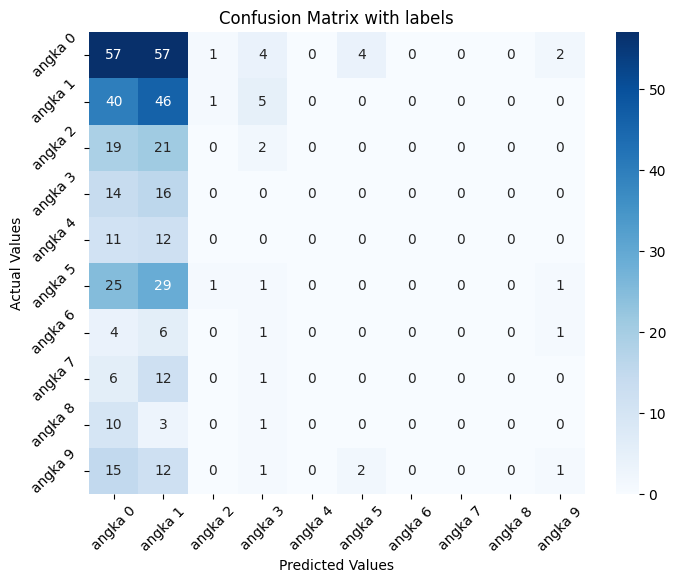

In [73]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan prediksi model dan label sebenarnya
def get_predictions_and_labels(model, data_generator):
    predictions = model.predict(data_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = data_generator.classes
    class_labels = list(data_generator.class_indices.keys())
    return predicted_classes, true_classes, class_labels

# Mendapatkan prediksi dan label sebenarnya untuk data uji
y_pred, y_true, class_labels = get_predictions_and_labels(model1c, test_generator)

# Membuat matriks konfusi
cf_matrix = confusion_matrix(y_true, y_pred)

# Membuat visualisasi matriks konfusi
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Menetapkan label dan judul
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Menetapkan label pada sumbu x dan y sesuai dengan jenis kelas
ax.xaxis.set_ticklabels(class_labels, rotation=45)
ax.yaxis.set_ticklabels(class_labels, rotation=45)

# Menampilkan visualisasi Matriks Konfusi
plt.show()

In [74]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.23370786516853934
